### Домашнее задание
Катастрофическое забывание

Цель:
Проверить влияние fine-tuning на исходную модель.


Описание/Пошаговая инструкция выполнения домашнего задания:
Скачать датасет ImageNette: https://github.com/fastai/imagenette (ImageNette это подвыборка из 10 классов датасета ImageNet).
Взять предобученную на обычном ImageNet модель (например, ResNet18) и заенить число классов на 10.
Дообучить модель на 10 классах ImageNette и замерить точность (это точность будет считаться базовой). Можно обучить как всю модель, так и только последний слой.
Сохранить последний слой на 10 классов (слой классификации).
Используя код с лекции дообучить модель классифицировать датасет CIFAR10.
Вернуть оригинальный последний слой модели и проверить качество на ImageNette и сравнить с базовой точностью.
Дообучить только последний слой (отключить градиент для всех слоев кроме последнего) на ImageNette и проверить удалось ли добиться исходного качества.
Сделать выводы

In [2]:
import torch
from torch import nn
from torchvision import models, datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.utils import make_grid

import os
import time
from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

c:\Users\julia\CV\OTUS_CV_10_Datasets_finetuning\venv\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\julia\CV\OTUS_CV_10_Datasets_finetuning\venv\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def set_requires_grad(model, value=False):
    for param in model.parameters():
        param.requires_grad = value

In [5]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

In [6]:
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [8]:
#создаём свой кастомный слой классификации
num_classes = 10

set_requires_grad(model, False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [9]:
next(model.fc.parameters()).requires_grad

True

In [10]:
def train_model(model, dataloaders, criterion, optimizer, phases, num_epochs=3):
    start_time = time.time()

    acc_history = {k: list() for k in phases}
    loss_history = {k: list() for k in phases}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, labels in tqdm(dataloaders[phase], total=n_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()
            epoch_acc /= len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))

    return model, acc_history

In [16]:
trainset = datasets.ImageFolder(root='./imagenette2/train', transform=transforms)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root='./imagenette2/val', transform=transforms)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

imagenette_loaders = {'train': trainloader, 'val': testloader}

In [18]:
print(trainset.class_to_idx)

{'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 'n03445777': 8, 'n03888257': 9}


In [19]:
len(trainloader), len(testloader)

(1184, 491)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


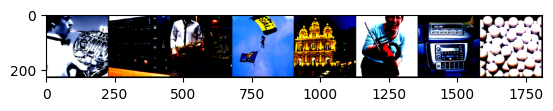

In [24]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(imagenette_loaders['train'])
images, labels = next(dataiter)

# Show images
imshow(make_grid(images))

## Дообучение модели на Imagenette 10 классов - все слои

In [25]:
set_requires_grad(model, True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

model = model.to(device)

model_imagenette, acc_imagenette_init = train_model(model, imagenette_loaders, criterion, optimizer, phases=['train', 'val'], num_epochs=10)

Epoch 0/9
----------


100%|██████████| 1184/1184 [00:59<00:00, 19.79it/s]


train Loss: 2.3013 Acc: 0.1644


100%|██████████| 491/491 [00:20<00:00, 23.59it/s]


val Loss: 2.1346 Acc: 0.2104

Epoch 1/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.23it/s]


train Loss: 2.0334 Acc: 0.2696


100%|██████████| 491/491 [00:13<00:00, 36.93it/s]


val Loss: 1.8204 Acc: 0.3931

Epoch 2/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.23it/s]


train Loss: 1.6910 Acc: 0.4196


100%|██████████| 491/491 [00:13<00:00, 37.18it/s]


val Loss: 1.5096 Acc: 0.5078

Epoch 3/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.31it/s]


train Loss: 1.3951 Acc: 0.5355


100%|██████████| 491/491 [00:13<00:00, 37.00it/s]


val Loss: 1.3511 Acc: 0.5722

Epoch 4/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.17it/s]


train Loss: 1.1959 Acc: 0.6051


100%|██████████| 491/491 [00:13<00:00, 37.27it/s]


val Loss: 1.1378 Acc: 0.6380

Epoch 5/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.30it/s]


train Loss: 1.0372 Acc: 0.6559


100%|██████████| 491/491 [00:13<00:00, 37.15it/s]


val Loss: 1.0207 Acc: 0.6680

Epoch 6/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.17it/s]


train Loss: 0.9475 Acc: 0.6866


100%|██████████| 491/491 [00:13<00:00, 37.21it/s]


val Loss: 0.9991 Acc: 0.7022

Epoch 7/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.31it/s]


train Loss: 0.8540 Acc: 0.7206


100%|██████████| 491/491 [00:13<00:00, 37.13it/s]


val Loss: 0.9430 Acc: 0.7045

Epoch 8/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.18it/s]


train Loss: 0.7753 Acc: 0.7470


100%|██████████| 491/491 [00:13<00:00, 37.06it/s]


val Loss: 0.9281 Acc: 0.7118

Epoch 9/9
----------


100%|██████████| 1184/1184 [00:58<00:00, 20.17it/s]


train Loss: 0.7211 Acc: 0.7647


100%|██████████| 491/491 [00:13<00:00, 37.23it/s]


val Loss: 0.8004 Acc: 0.7483

Training complete in 12m 11s


In [26]:
fc_weights_imagenette = model_imagenette.fc.weight.data
fc_bias_imagenette = model_imagenette.fc.bias.data

### Дообучение модели на CIFAR10

Используя код с лекции дообучить модель классифицировать датасет CIFAR10.

In [27]:
cifar_10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
cifar_10_trainloader = torch.utils.data.DataLoader(cifar_10_trainset, batch_size=16, shuffle=True, num_workers=4)

cifar_10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
cifar_10_testloader = torch.utils.data.DataLoader(cifar_10_testset, batch_size=16, shuffle=False, num_workers=4)

cifar_10_loaders = {'train': cifar_10_trainloader, 'val': cifar_10_testloader}
cifar_10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:07<00:00, 21515333.59it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [28]:
model_cifar_10, acc_cifar_10 = train_model(model_imagenette, cifar_10_loaders, criterion, optimizer, phases=['train', 'val'], num_epochs=10)

Epoch 0/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.45it/s]


train Loss: 1.1295 Acc: 0.6014


100%|██████████| 625/625 [00:28<00:00, 21.75it/s]


val Loss: 0.8582 Acc: 0.7020

Epoch 1/9
----------


100%|██████████| 3125/3125 [04:09<00:00, 12.52it/s]


train Loss: 0.7963 Acc: 0.7249


100%|██████████| 625/625 [00:28<00:00, 22.06it/s]


val Loss: 0.7259 Acc: 0.7479

Epoch 2/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.47it/s]


train Loss: 0.6893 Acc: 0.7628


100%|██████████| 625/625 [00:28<00:00, 22.22it/s]


val Loss: 0.6771 Acc: 0.7705

Epoch 3/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.47it/s]


train Loss: 0.6292 Acc: 0.7841


100%|██████████| 625/625 [00:28<00:00, 22.19it/s]


val Loss: 0.7355 Acc: 0.7563

Epoch 4/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.50it/s]


train Loss: 0.5899 Acc: 0.7986


100%|██████████| 625/625 [00:28<00:00, 22.03it/s]


val Loss: 0.6716 Acc: 0.7689

Epoch 5/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.46it/s]


train Loss: 0.5623 Acc: 0.8072


100%|██████████| 625/625 [00:28<00:00, 22.23it/s]


val Loss: 0.6559 Acc: 0.7753

Epoch 6/9
----------


100%|██████████| 3125/3125 [04:09<00:00, 12.50it/s]


train Loss: 0.5387 Acc: 0.8144


100%|██████████| 625/625 [00:28<00:00, 22.06it/s]


val Loss: 0.6164 Acc: 0.7869

Epoch 7/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.48it/s]


train Loss: 0.5281 Acc: 0.8193


100%|██████████| 625/625 [00:28<00:00, 21.88it/s]


val Loss: 0.5651 Acc: 0.8099

Epoch 8/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.46it/s]


train Loss: 0.5146 Acc: 0.8219


100%|██████████| 625/625 [00:28<00:00, 22.02it/s]


val Loss: 0.5809 Acc: 0.8056

Epoch 9/9
----------


100%|██████████| 3125/3125 [04:10<00:00, 12.48it/s]


train Loss: 0.5050 Acc: 0.8260


100%|██████████| 625/625 [00:28<00:00, 21.98it/s]


val Loss: 0.6343 Acc: 0.7842

Training complete in 46m 34s


### Вернуть оригинальный последний слой модели и проверить качество на ImageNette и сравнить с базовой точностью.

In [29]:
model_cifar_10.fc.weight.data = fc_weights_imagenette
model_cifar_10.fc.bias.data = fc_bias_imagenette

model_image_on_cifar, acc_image_on_cifar = train_model(model_cifar_10, imagenette_loaders, criterion, optimizer, phases=['val'], num_epochs=1)

Epoch 0/0
----------


100%|██████████| 491/491 [00:14<00:00, 34.67it/s]


val Loss: 4.7973 Acc: 0.0568

Training complete in 0m 14s


In [30]:
acc_image_on_cifar

{'val': [tensor(0.0568, device='cuda:0', dtype=torch.float64)]}

In [35]:
acc_imagenette_init['val'][-1], acc_cifar_10['val'][-2], acc_image_on_cifar['val'][-1]

(tensor(0.7483, device='cuda:0', dtype=torch.float64),
 tensor(0.8056, device='cuda:0', dtype=torch.float64),
 tensor(0.0568, device='cuda:0', dtype=torch.float64))

### Дообучить только последний слой (отключить градиент для всех слоев кроме последнего) на ImageNette и проверить удалось ли добиться исходного качества.


In [32]:
set_requires_grad(model_cifar_10, False)
set_requires_grad(model_cifar_10.fc, True)

model_image_2, acc_mage_2 = train_model(model_cifar_10, imagenette_loaders, criterion, optimizer, phases=['train', 'val'], num_epochs=10)

Epoch 0/9
----------


100%|██████████| 1184/1184 [00:25<00:00, 46.10it/s]


train Loss: 1.6588 Acc: 0.4686


100%|██████████| 491/491 [00:13<00:00, 36.09it/s]


val Loss: 1.2837 Acc: 0.5661

Epoch 1/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 49.99it/s]


train Loss: 1.3378 Acc: 0.5501


100%|██████████| 491/491 [00:13<00:00, 36.40it/s]


val Loss: 1.2430 Acc: 0.5791

Epoch 2/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.22it/s]


train Loss: 1.3118 Acc: 0.5612


100%|██████████| 491/491 [00:13<00:00, 37.17it/s]


val Loss: 1.2316 Acc: 0.5781

Epoch 3/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.35it/s]


train Loss: 1.2976 Acc: 0.5647


100%|██████████| 491/491 [00:13<00:00, 36.73it/s]


val Loss: 1.2021 Acc: 0.5969

Epoch 4/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.53it/s]


train Loss: 1.2844 Acc: 0.5744


100%|██████████| 491/491 [00:13<00:00, 36.70it/s]


val Loss: 1.2062 Acc: 0.5934

Epoch 5/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.16it/s]


train Loss: 1.2749 Acc: 0.5746


100%|██████████| 491/491 [00:13<00:00, 37.06it/s]


val Loss: 1.2216 Acc: 0.5829

Epoch 6/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.43it/s]


train Loss: 1.2738 Acc: 0.5792


100%|██████████| 491/491 [00:13<00:00, 37.12it/s]


val Loss: 1.2030 Acc: 0.5959

Epoch 7/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.43it/s]


train Loss: 1.2687 Acc: 0.5740


100%|██████████| 491/491 [00:13<00:00, 36.99it/s]


val Loss: 1.2083 Acc: 0.5837

Epoch 8/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.04it/s]


train Loss: 1.2702 Acc: 0.5768


100%|██████████| 491/491 [00:13<00:00, 36.53it/s]


val Loss: 1.1992 Acc: 0.5952

Epoch 9/9
----------


100%|██████████| 1184/1184 [00:23<00:00, 50.25it/s]


train Loss: 1.2624 Acc: 0.5762


100%|██████████| 491/491 [00:13<00:00, 36.92it/s]


val Loss: 1.1936 Acc: 0.5992

Training complete in 6m 16s


In [53]:
f"{acc_imagenette_init['val'][-1]}, {acc_cifar_10['val'][-2]}, {acc_image_on_cifar['val'][-1]}, {acc_mage_2['val'][-1]} "

formatted_string = (f"1) Дообученная модель на 10 классах ImageNette:  val_acc на ImageNette =  {round(float(acc_imagenette_init['val'][-1]), 3)}\n"
                    f"2) Дообученная модель на датасете CIFAR10     :  val_acc на  CIFAR10   =  {round(float(acc_cifar_10['val'][-2]), 3)}\n"
                    f"3) Модель №2 с fc слоем модели №1             :  val_acc на ImageNette =  {round(float(acc_image_on_cifar['val'][-1]), 3)}\n"
                    f"4) Модель №3 снова обученная на ImageNette    :  val_acc на ImageNette =  {round(float(acc_mage_2['val'][-1]), 3)}")

print(formatted_string)

1) Дообученная модель на 10 классах ImageNette:  val_acc на ImageNette =  0.748
2) Дообученная модель на датасете CIFAR10     :  val_acc на  CIFAR10   =  0.806
3) Модель №2 с fc слоем модели №1             :  val_acc на ImageNette =  0.057
4) Модель №3 снова обученная на ImageNette    :  val_acc на ImageNette =  0.599


### Сделать выводы

После повторного дообучения точность модели не восстановилась до изначального значения, что демонстрирует концепцию катастрофического забывания